In [1]:
%load_ext autoreload
%autoreload 2

import jax  # noqa: I001
jax.config.update("jax_enable_x64", True)

import numpyro  # noqa: E402, I001
numpyro.set_host_device_count(4)

import numpy as np  # noqa: E402, I001

import ultraplot as uplt  # noqa: E402, I001

## Fit the Data

In [14]:
import h5py

from des_y6_imsim_analysis import interpolant
from des_y6_imsim_analysis.utils import ModelData, read_data

if True:
    with h5py.File("../../data/N_gamma_alpha_v3_statistical_y3-complement.hdf5", "r") as d:
        mn = d["shear/mean"][:].astype(np.float64)
        cov = d["shear/cov"][:].astype(np.float64)
        mn_pars = d["shear/mean_params"][:].astype(np.int64)
        mn_pars[:, 1] = 0
        mn_pars = tuple(
            tuple(v) for v in mn_pars.tolist()
        )

        zbins = []
        for zbin in range(-1, 10):
            zbins.append(d[f"alpha/bin{zbin}"][:].astype(np.float64))
        zbins = np.array(zbins)

        z = d["redshift/zbinsc"][:].astype(np.float64)
        if np.allclose(z[0], 0.0):
            cutind = 1
        else:
            cutind = 0
        z = z[cutind:]

        nzs = []
        for _bin in [-1]:
            nzs.append(d[f"redshift/bin{_bin}"][:].astype(np.float64))
            nzs[-1] = nzs[-1][cutind:] / np.sum(nzs[-1][cutind:])
        nzs = np.array(nzs, dtype=np.float64).reshape((1, -1))

        data = ModelData(z=z, nzs=nzs, mn_pars=mn_pars, zbins=zbins, mn=mn, cov=cov)
else:
    data = read_data("../../data/N_gamma_alpha_v3_statistical_y3-complement.hdf5")

model_module = interpolant

kwargs = {
    "num_pts": 10,
    "model_kind": "g",
}
# kwargs = {
#     "num_pts": 9,
#     "model_kind": "F",
#     "fixed_param_values": {
#         "g_b0": 0.0, "g_b1": 0.0, "g_b2": 0.0, "g_b3": 0.0,
#     },
# }

model_data = model_module.make_model_data(
    z=data.z,
    nzs=data.nzs,
    mn=data.mn,
    cov=data.cov,
    mn_pars=data.mn_pars,
    zbins=data.zbins,
    **kwargs,
)

In [15]:
from des_y6_imsim_analysis.stats import measure_map

map_params = measure_map(
    model_module=model_module,
    model_data=model_data,
    seed=254,
    progress_bar=True,
    num_steps=50_000,
    learning_rate=1e-2,
)

100%|██████████| 50000/50000 [00:10<00:00, 4650.88it/s, init loss: 57016.6121, avg. loss [47501-50000]: -52.0346]


In [16]:
import pprint

from des_y6_imsim_analysis.stats import compute_model_chi2_info

chi2_info = compute_model_chi2_info(
    model_module=model_module,
    model_data=model_data,
    data=data,
    params=map_params,
)

print("chi2:", chi2_info['chi2'])
print("dof:", chi2_info['dof'])
print("p-value:", chi2_info['p_value'])
print("m vals:\n    model: %r\n    data: %r\n     err: %r" % (
    (chi2_info['model_mn'][:data.nzs.shape[0]] - 1).tolist(),
    (data.mn[:data.nzs.shape[0]] - 1).tolist(),
    (np.sqrt(np.diag(data.cov)[:data.nzs.shape[0]])).tolist(),
))
print("map params:\n", pprint.pformat(map_params))

chi2: 3.1844514413794496
dof: 1
p-value: 0.07434194572995778
m vals:
    model: [0.003256402494299815]
    data: [0.0025706942284355883]
     err: [0.007950235819915044]
map params:
 {'a0_b0': Array(0.4891032, dtype=float64),
 'a1_b0': Array(0.5167002, dtype=float64),
 'a2_b0': Array(0.50993549, dtype=float64),
 'a3_b0': Array(0.51952676, dtype=float64),
 'a4_b0': Array(0.4913889, dtype=float64),
 'a5_b0': Array(0.49442676, dtype=float64),
 'a6_b0': Array(0.4911748, dtype=float64),
 'a7_b0': Array(0.4964036, dtype=float64),
 'a8_b0': Array(0.49563679, dtype=float64),
 'a9_b0': Array(0.49776642, dtype=float64)}


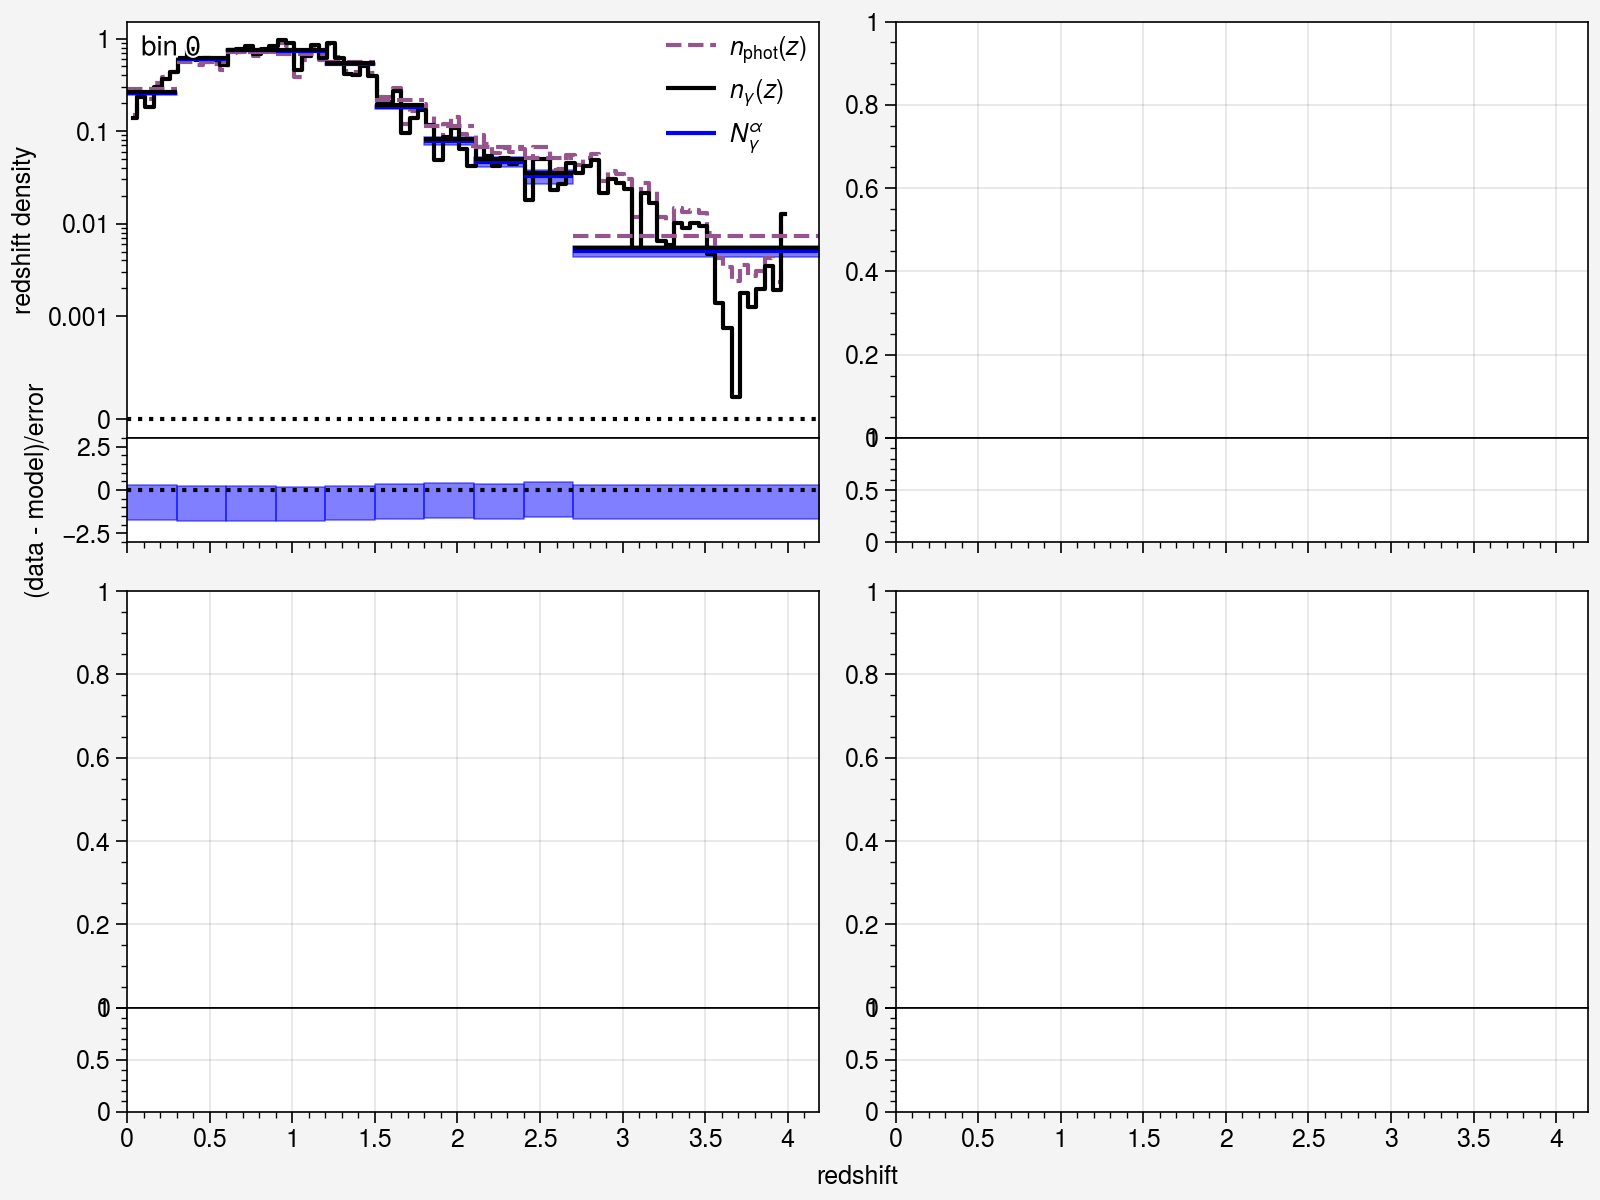

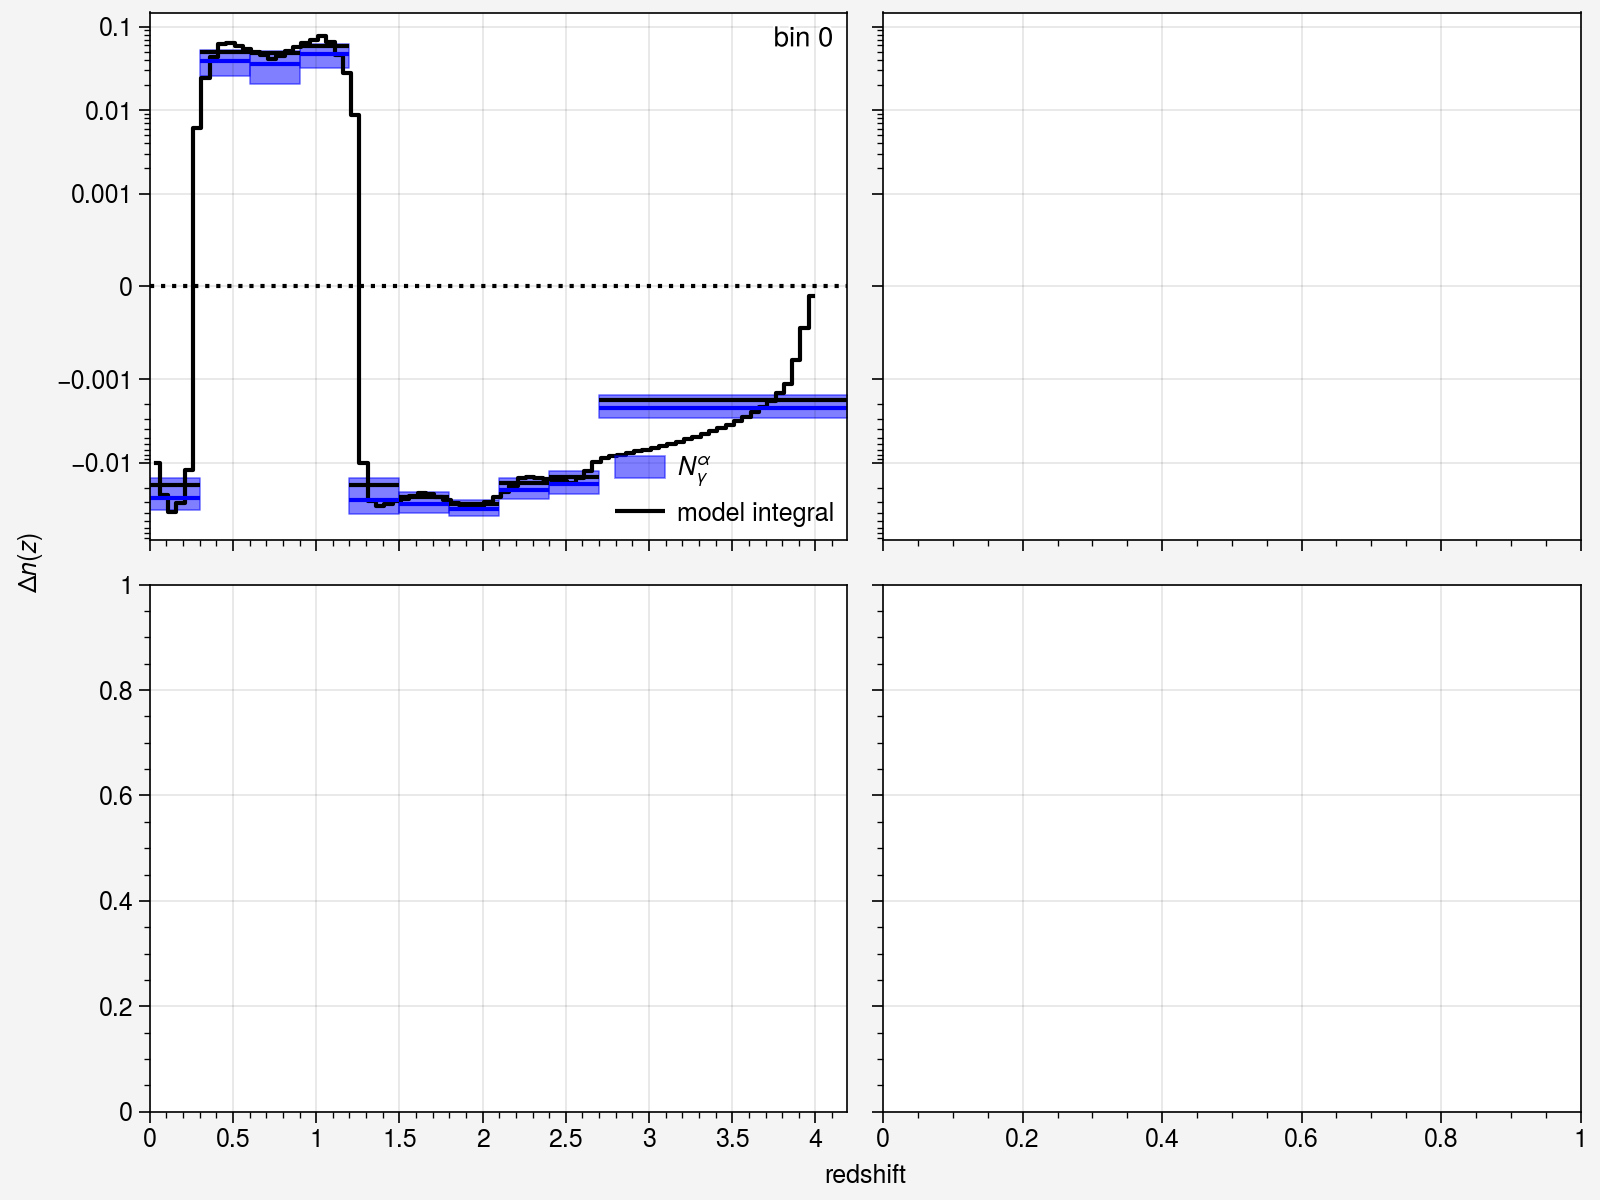

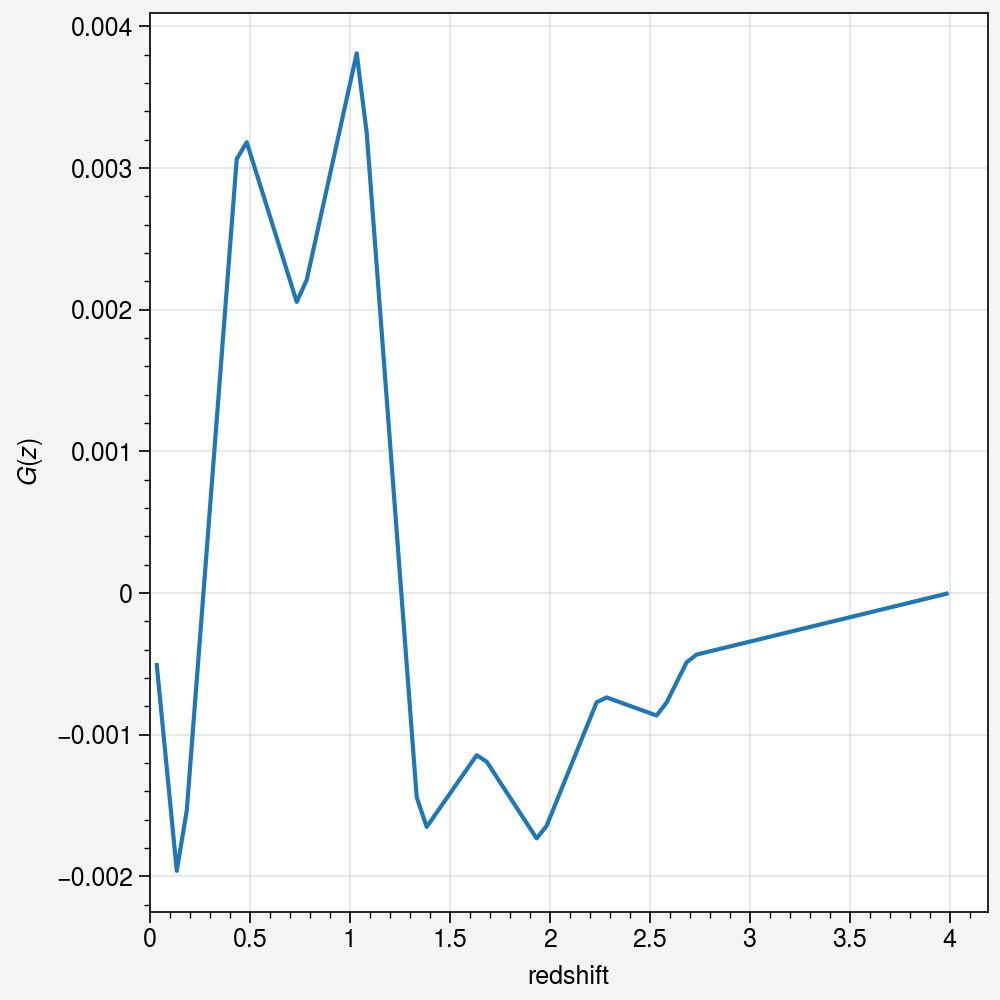

In [17]:
from des_y6_imsim_analysis.utils import (
    plot_results_delta_nz,
    plot_results_fg_model,
    plot_results_nz,
)

fig = plot_results_nz(model_module=model_module, model_data=model_data, map_params=map_params)
fig = plot_results_delta_nz(model_module=model_module, model_data=model_data, map_params=map_params, symlog=True)
fig = plot_results_fg_model(model_module=model_module, model_data=model_data, map_params=map_params)

In [18]:
from des_y6_imsim_analysis.stats import run_mcmc

mcmc = run_mcmc(
    model_module=model_module,
    model_data=model_data,
    init_params=map_params,
    seed=231,
    progress_bar=True,
    dense_mass=True,
    num_samples=2000,
)

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

In [19]:
mcmc.print_summary(exclude_deterministic=False)
samples = mcmc.get_samples()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     a0_b0      0.49      0.00      0.49      0.48      0.50  13141.39      1.00
     a1_b0      0.52      0.00      0.52      0.51      0.52  12466.56      1.00
     a2_b0      0.51      0.01      0.51      0.50      0.52  13856.89      1.00
     a3_b0      0.52      0.00      0.52      0.51      0.53  13671.57      1.00
     a4_b0      0.49      0.00      0.49      0.48      0.50  13024.42      1.00
     a5_b0      0.49      0.00      0.49      0.49      0.50  14687.38      1.00
     a6_b0      0.49      0.00      0.49      0.49      0.50  14883.71      1.00
     a7_b0      0.50      0.00      0.50      0.49      0.50  16734.75      1.00
     a8_b0      0.50      0.00      0.50      0.49      0.50  13562.65      1.00
     a9_b0      0.50      0.00      0.50      0.50      0.50  10368.33      1.00

Number of divergences: 0


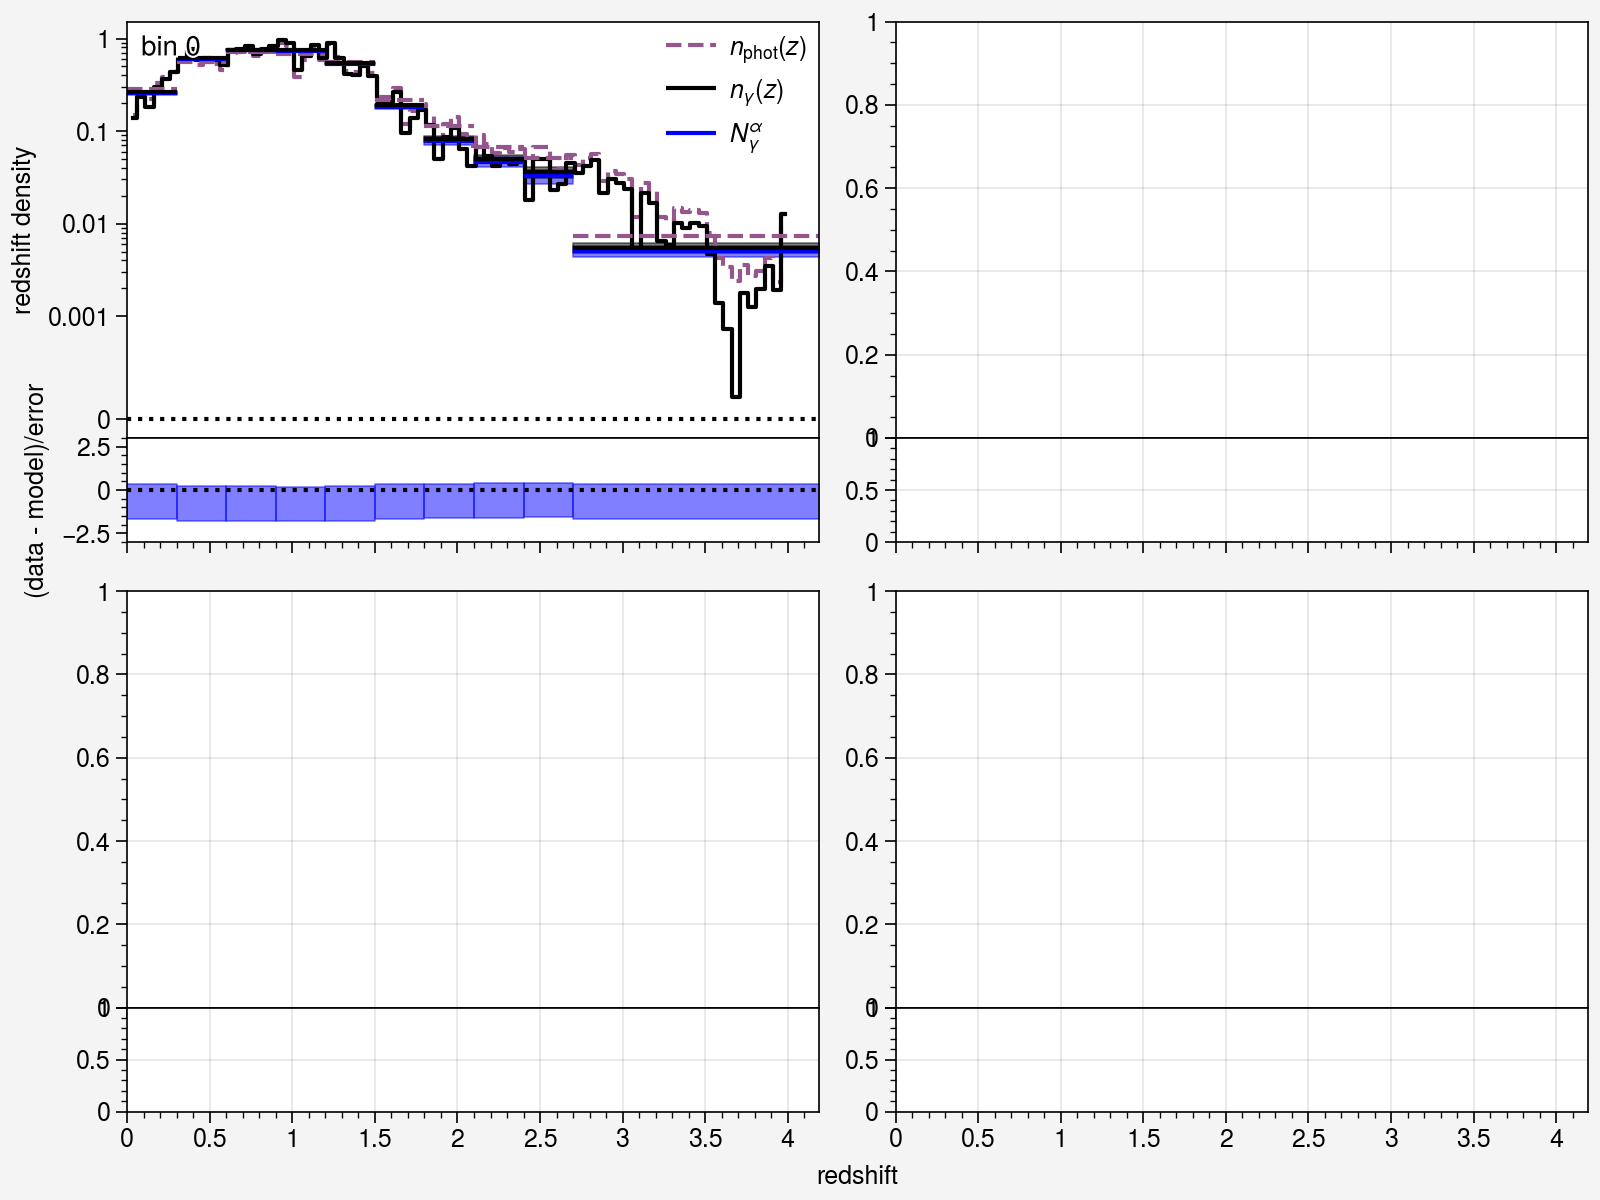

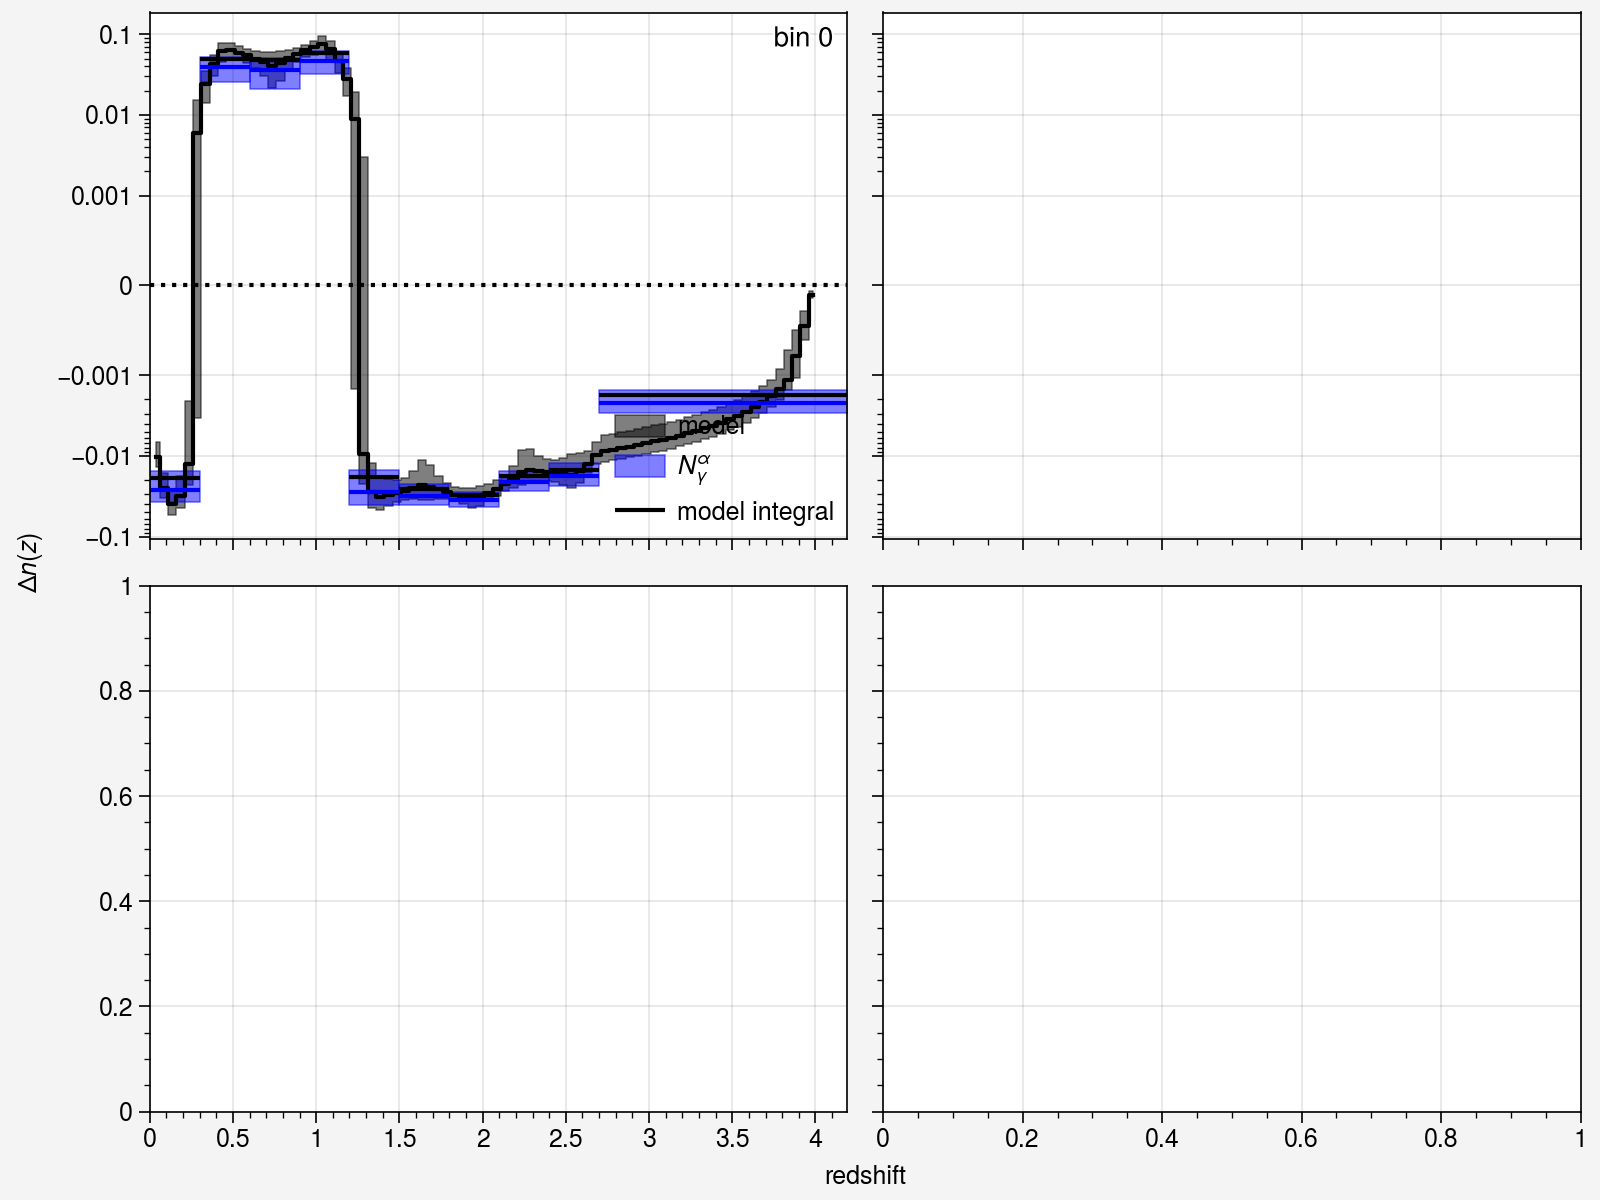

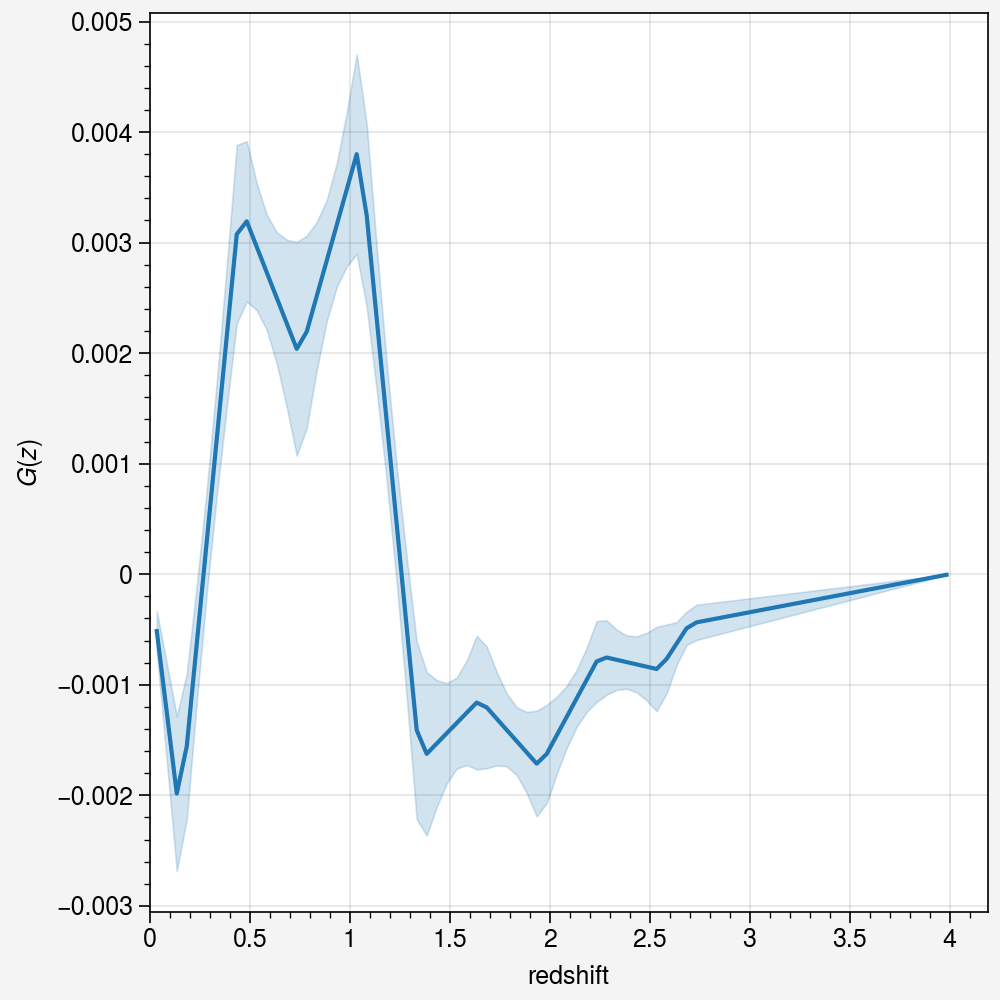

In [20]:
from des_y6_imsim_analysis.utils import (
    plot_results_delta_nz,
    plot_results_fg_model,
    plot_results_nz,
)

fig = plot_results_nz(model_module=model_module, model_data=model_data, samples=samples)
fig = plot_results_delta_nz(model_module=model_module, model_data=model_data, samples=samples)
fig = plot_results_fg_model(model_module=model_module, model_data=model_data, samples=samples)

In [21]:
from des_y6_imsim_analysis.utils import measure_m_dz

mdz = measure_m_dz(
    model_module=model_module,
    model_data=model_data,
    samples=samples,
    return_dict=True,
    shift_negative=True,
)

In [22]:
m_mn = [np.mean(mdz[f"m_b{i}"]) for i in range(4)]
m_sd = [np.std(mdz[f"m_b{i}"]) for i in range(4)]

dz_mn = [np.mean(mdz[f"dz_b{i}"]) for i in range(4)]
dz_sd = [np.std(mdz[f"dz_b{i}"]) for i in range(4)]

print("|--------------------------------------------|")
print("| bin | m [10^-3, 3sigma] | dz               |")
print("|--------------------------------------------|")
for i in range(data.nzs.shape[0]):
    print(
        "| %d   | %+5.1f +/- %-5.1f   | %+0.3f +/- %0.3f |" % (
            i, m_mn[i]/1e-3, m_sd[i]/1e-3 * 3, dz_mn[i], dz_sd[i]
        )
    )
print("|--------------------------------------------|")

|--------------------------------------------|
| bin | m [10^-3, 3sigma] | dz               |
|--------------------------------------------|
| 0   |  +3.2 +/- 23.8    | -0.048 +/- 0.007 |
|--------------------------------------------|


mdz_arr shape: (1000, 8)
(8, 8)


/Users/beckermr/mambaforge/envs/des-y6/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/beckermr/mambaforge/envs/des-y6/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


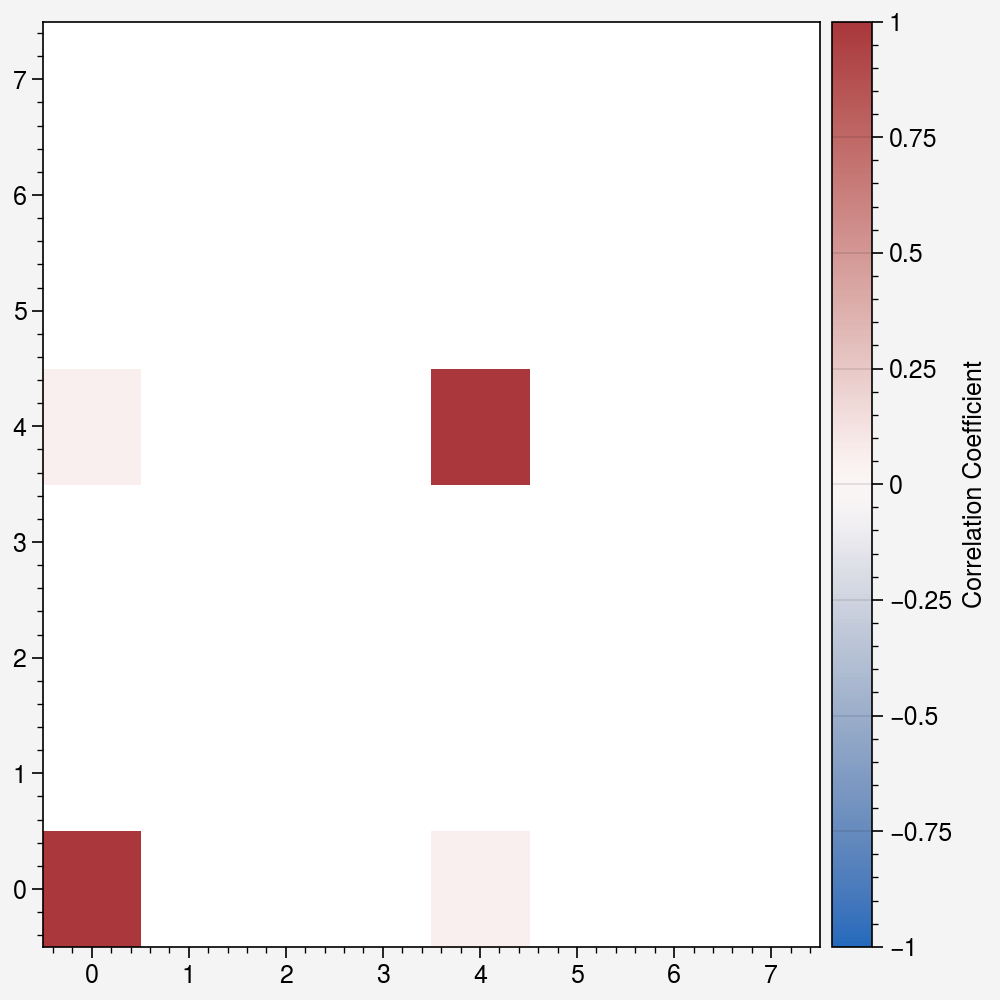

In [23]:
mdz_arr = np.vstack(
    [mdz[f"m_b{i}"] for i in range(4)]
    + [mdz[f"dz_b{i}"] for i in range(4)],
).T
print("mdz_arr shape:", mdz_arr.shape)

corr = np.corrcoef(mdz_arr.T)
print(corr.shape)

fig, axs = uplt.subplots(figsize=(5, 5))

m = axs.pcolormesh(corr, vmin=-1, vmax=1, cmap="vlag", discrete=False)
axs.colorbar(m, label="Correlation Coefficient")
axs.format(grid=False)